## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne

import warnings
warnings.filterwarnings('ignore')

# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [84]:
def print_graphs(data):
    for i in range(0, 40):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 40):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 40):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [85]:
data_beta = np.load("../../datasets/beta/data_beta.npy")
print(data_beta.shape)
# data_multi = data_multi.reshape(data_multi.shape[0]*data_multi.shape[1], data_multi.shape[2])
# data_multi = data_multi.reshape(-1, data_multi.shape[-1])
# print(data_multi.shape)


(160, 64, 750)


Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

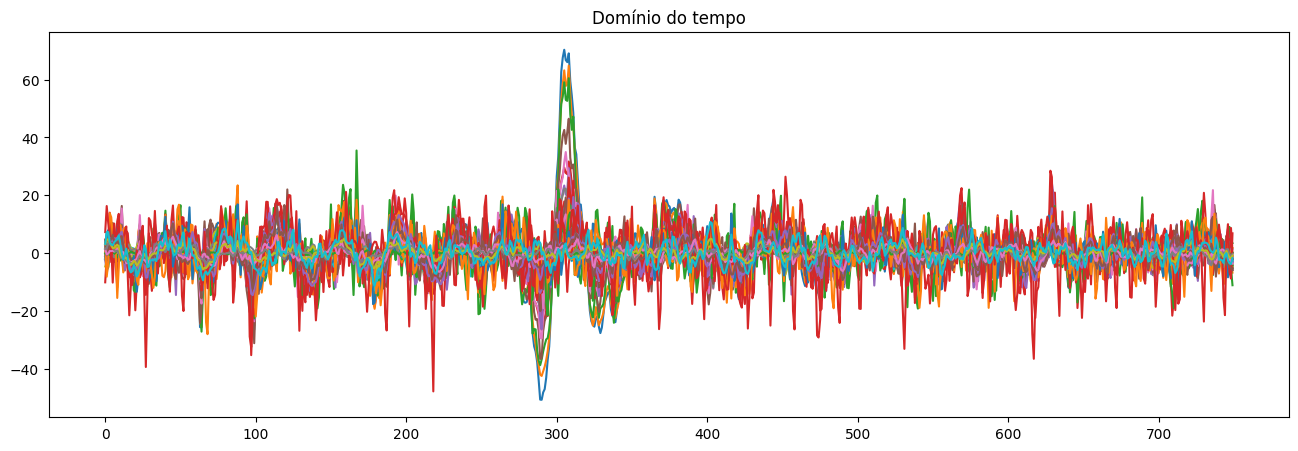

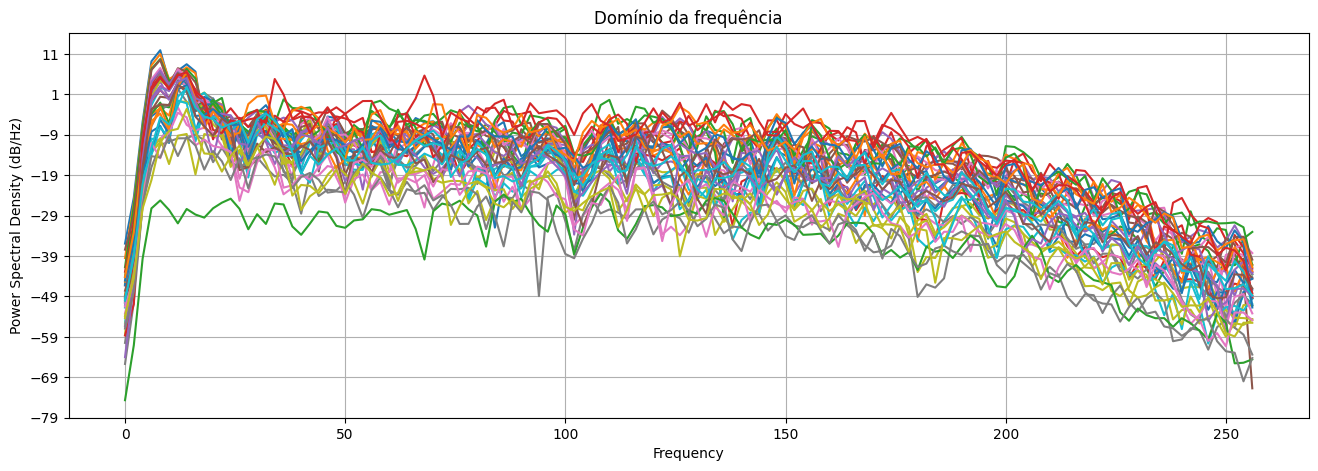

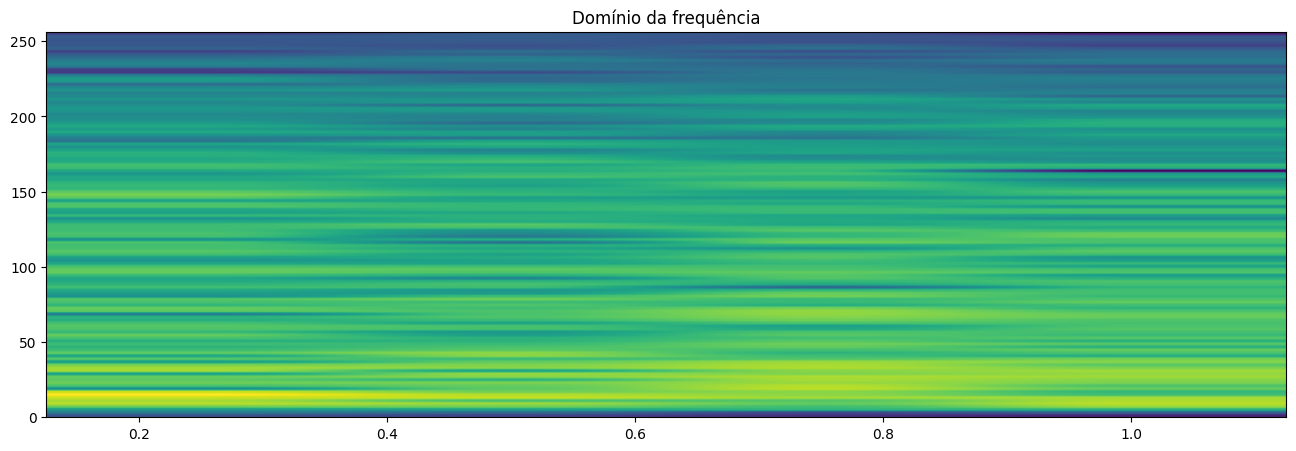

In [86]:
rcParams['figure.figsize'] = [16., 5.]
# print_graphs(data_beta[0])
print_graphs(data_beta[0])


Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [93]:
# criação de um objeto "info"
best_ch = ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']
# best_ch = ['P6', 'PO3']

n_channels = 64
sfreq = 250
ch_names = list(np.load("../../datasets/beta/channels.npy"))
ch_types = ['eeg'] * len(ch_names)
# ch_types = ['eeg'] * len(electrode_names)
# info = mne.create_info(electrode_names, sfreq=sfreq, ch_types=ch_types)
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
>

In [88]:
labels = np.load("../../datasets/beta/labels_beta.npy")
print(labels.shape)

# labels = labels.reshape(labels.shape[0] * labels.shape[1])
print(labels, labels.shape)



(160,)
[ 8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2
 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.
 14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4  8.6  8.8
  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6
 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.  14.2 14.4
 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4  8.6  8.8  9.   9.2
  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.
 12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8
 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6
  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4
 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2
 15.4 15.6 15.8  8.   8.2  8.4] (160,)


In [89]:
# método para transformar labels categóricos

# info = mne.pick_info(info, mne.pick_channels(info['ch_names'], electrode_names))

# data_correct = data_beta
# data_correct_reduced = data_correct[:, [info['ch_names'].index(ear) for ear in electrode_names], :]


le = LabelEncoder()

events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(160, dtype=int),
    le.fit_transform(labels))
)

set_labels = sorted(set(labels))

event_dict = {str(value): index for index, value in enumerate(set_labels)}
mne_data = mne.EpochsArray(data_beta, info, events, event_id=event_dict)

# ch_drop = [ch for ch in ch_names if ch not in best_ch]
# mne_data = mne_data.drop_channels(ch_drop)

# mne_data

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated


In [90]:
# for i in range(len(mne_data)):
#     # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
#     view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13, verbose=False)
#     view.plot(show=False)
#     print()
#     plt.title('Domínio da frequência')
#     plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--', color='green')
#     plt.show()
# print()

### Tarefas

- Estudar e utilizar os exemplos já apresentados no repositório `tutoriais` e criar o objeto `mne.EpochArray` para os dados *single* e *multi-target* (`AVI dataset`);
- Estudar documentos MNE para realizar a aplicação dos filtros temporais a partir de objetos `mne.EpochArray` (sempre verificando as frequências utilizadas como targets dos `datasets`). Isto também para os dados *single* e *multi-target* (`AVI dataset`);
- **Ótimo**: elaborar toda a aplicação já realizada até o ponto anterior para o *dataset* `Beta`.

In [91]:
# aplicando o filtro
mne_data_filtered = mne_data.filter(l_freq=7., h_freq=17)

# salvando os dados
mne_data_filtered.save(fname="mne_data_beta.fif", overwrite=True)
mne_data_filtered

Setting up band-pass filter from 7 - 17 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 17.00 Hz
- Upper transition bandwidth: 4.25 Hz (-6 dB cutoff frequency: 19.12 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s


[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 5201 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 5831 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 6497 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 7937 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 8711 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 9521 tasks      | elapsed:    1.8s


Overwriting existing file.


Number of events,160
Events,10.0: 410.2: 410.4: 410.6: 410.8: 411.0: 411.2: 411.4: 411.6: 411.8: 412.0: 412.2: 412.4: 412.600000000000001: 412.8: 413.0: 413.200000000000001: 413.4: 413.600000000000001: 413.8: 414.0: 414.200000000000001: 414.4: 414.600000000000001: 414.8: 415.0: 415.200000000000001: 415.4: 415.600000000000001: 415.8: 48.0: 48.2: 48.4: 48.6: 48.799999999999999: 49.0: 49.2: 49.4: 49.6: 49.8: 4
Time range,0.000 – 2.996 s
Baseline,off
